## Compare Euler and Miltstein Solver

#### (a) Visualization

Simulate:
$$
    dX_t = aX_tdt + bX_tdW_t, X_0 = 1
$$ whose exact solution is:
$$
    X_t = \exp\bigg[
        (a-\frac{b^2}{2})t + bW_t
    \bigg]
$$


Recall Euler scheme:
$$
    X_{n+1} = X_n + aX_n\Delta t + bX_n(W_{n+1}-W_n), W_{n+1}-W_n= \sqrt{\Delta t}Z, Z\sim \mathcal{N}(0,1)
$$

And Milstein scheme:
$$
    X_{n+1} = X_n + aX_n\Delta t + bX_n\Delta W_n+\frac12b^2X_n((\Delta W_n)^2-\Delta t)
$$ where $\Delta W_n = W_{n+1}-W_n$.

For sufficient resolution, we estimate the exact solution with a small step size, such as $\Delta t=0.0001$.

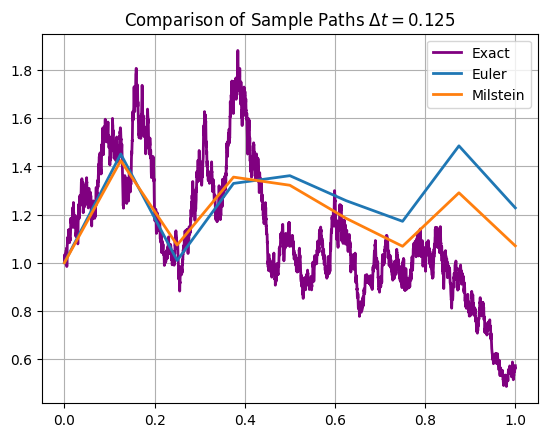

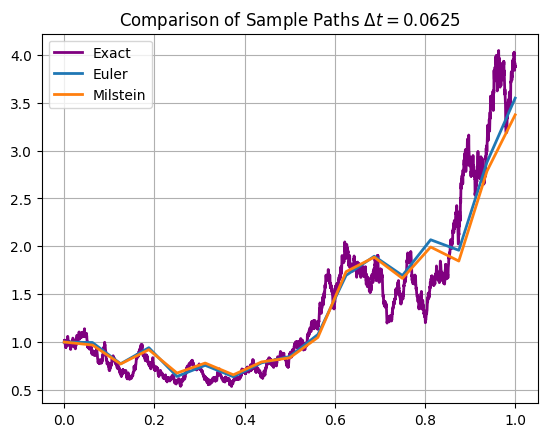

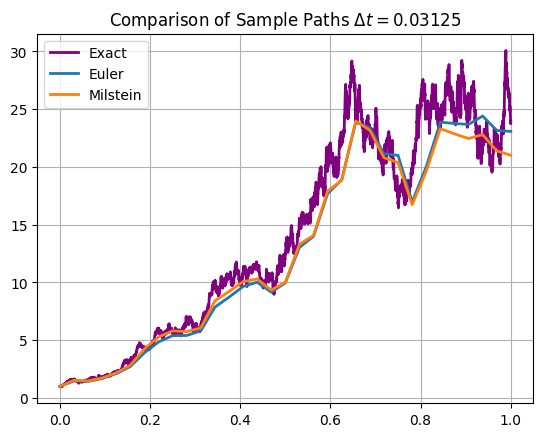

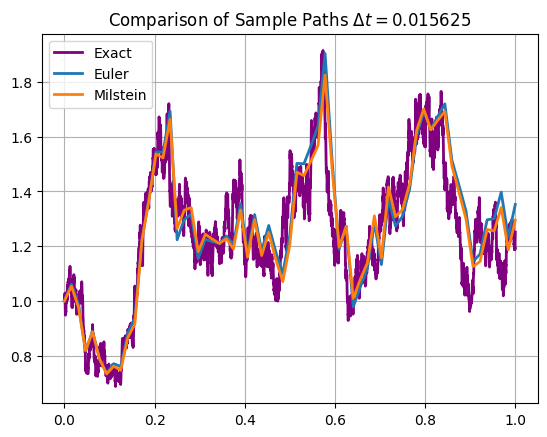

In [1]:
# numerical libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

# helper function
def exact_solution(dWt):
    nt = len(dWt)
    dt = 1/nt
    X_exact = [0]
    for i in range(nt):
        X_exact.append(X_exact[-1]+dt+dWt[i])
    X_exact = [np.exp(i) for i in X_exact]
    return X_exact
    


# fix seed
np.random.seed(10)
# fixed params
a = 1.5
b = 1
# configure
all_n = np.array([3, 4, 5, 6])
num_trials = len(all_n)
all_dt = np.array([1/(2**s) for s in all_n])
dt_exact = 2**(-12)
t_exact = np.arange(0, 1+dt_exact, dt_exact)
nt_exact = len(t_exact)

for i in range(num_trials):
    dt = all_dt[i]
    # time grid
    t = np.arange(0, 1+dt, dt)
    nt = len(t)
    
    # simulate a Wiener process using the fine discretization
    dWt = np.sqrt(dt_exact)*np.random.randn(int(1/dt_exact))
    # exact solution
    X_exact = exact_solution(dWt)
    # need to query the Wiener process at coarser leve;
    reduce = int(nt_exact/nt)
    sub_dWt = np.array([np.sum(dWt[(reduce*i):(reduce*(i+1))]) for i in range(nt)])
    
    X_euler = np.zeros(nt)
    X_mil = np.zeros(nt)
    X_euler[0] = 1
    X_mil[0] = 1

    for j in np.arange(0, nt-1):
        # Euler scheme
        X_euler[j+1] = X_euler[j] + a*X_euler[j]*dt + b*X_euler[j]*sub_dWt[j]
        # Milstein scheme
        X_mil[j+1] = X_mil[j] + a*X_mil[j] * dt + b*X_mil[j] * sub_dWt[j] + 0.5*X_mil[j]*((sub_dWt[j])**2-dt)
    # plotting
    plt.figure(i);
    plt.plot(t_exact, X_exact, lw=2, color='purple')
    plt.plot(t, X_euler, t, X_mil, lw=2);
    plt.legend(['Exact', 'Euler', 'Milstein']); plt.title(r"Comparison of Sample Paths $\Delta t = {}$".format(dt))
    plt.grid(True);

#### (b) Sample Generation

To compare at the final time, the exact solution is computed using a fine discretization, $\Delta t = 2^{-12}$.

In [2]:
# fix seed
mc = 5000

err_euler = np.zeros([num_trials, mc])
err_mil = np.zeros([num_trials, mc])
all_dt = [2**(-i) for i in range(3, 7)]
dt_exact = 2**(-12)
t_exact = np.arange(0, 1+dt_exact, dt_exact)
nt_exact = len(t_exact)
for i in range(mc):
    # generate exact solution using a fine level
    dWt = np.sqrt(dt_exact)*np.random.normal(loc=0, scale=1, size=nt_exact)
    Wt = np.cumsum(dWt)
    # exact solution
    X_exact = exact_solution(dWt)
    for k in range(3, 7):
        dt = 1/(2**k)
        t = np.arange(0, 1+dt, dt)
        nt = len(t)
        # compute Euler and Milstein solutions
        reduce = int(nt_exact/nt)
        sub_dWt = np.array([np.sum(dWt[(reduce*zz):(reduce*(zz+1))]) for zz in range(nt)])
        # exact solution query points
        X_exact_query = np.array([X_exact[(reduce*zz)] for zz in range(nt)])
        X_euler = np.zeros(nt)
        X_mil = np.zeros(nt)
        X_euler[0] = 1
        X_mil[0] = 1
        for j in np.arange(0, nt-1):
            # Euler scheme
            X_euler[j+1] = X_euler[j] + a*X_euler[j]*dt + b*X_euler[j]*sub_dWt[j]
            # Milstein scheme
            X_mil[j+1] = X_mil[j] + a*X_mil[j] * dt + b*X_mil[j] * sub_dWt[j] + 0.5*X_mil[j]*((sub_dWt[j])**2 - dt)
        # compute final error
        err_euler[k-3, i] = np.max(np.abs(X_euler-X_exact_query))
        err_mil[k-3, i] = np.max(np.abs(X_mil-X_exact_query))

#### Convergence plot

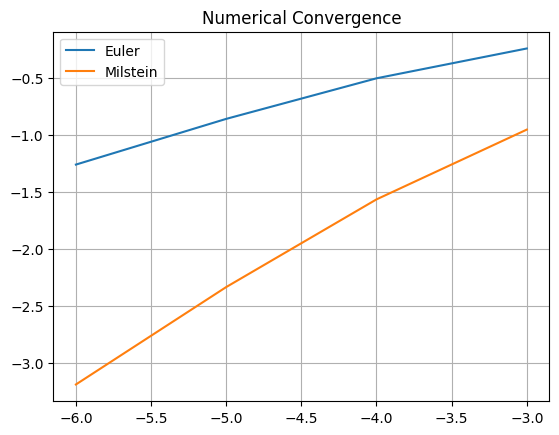

In [3]:
plt.figure(1);
plt.plot(np.log2(all_dt), np.log2(err_euler.mean(1)), np.log2(all_dt), np.log2(err_mil.mean(1)));
plt.legend(['Euler', 'Milstein']);
plt.title('Numerical Convergence'); 
plt.grid(True);